In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from collections import OrderedDict


In [4]:
import sys, os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
sn.set()

import matplotlib.font_manager as fm
fl = fm.FontProperties(fname ="C:\Windows\Fonts\malgun.ttf").get_name()
plt.rc('font',family=fl)

from patsy import dmatrices
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from mnist import load_mnist
from PIL import Image
import pickle


## 인공지능 기말 프로젝트

   1) output layer는 softmax 함수 값으로 정의

  2) hidden layer는 최소 3개 이상, 각 layer의 neuron 개수는 임의로 설정

  3) activation 함수는 Relu와 Sigmoid 에서 선택(혼합 가능)

  4) 가중치 기울기(dw)는 오차역전파(backpropagation)를 이용해서 구함

  5) 신경망 모형 학습 개선을 위한 보정 추가

     - Regularization, dropout, optimizer(momentum, RMSprop, Adam), weight-initialization(He or Xavier), batch-normalization 등

  6) Accuracy 결과 보고

## 노말 - 오차역전파 

In [5]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 

class FourLayerNet():    
    def __init__(self, input_size, hidden_size_1,hidden_size_2, hidden_size_3  ,output_size, weight_init_std = 0.01):
        
        # 가중치 초기화 
        self.params = {} 
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size_1)
        self.params['b1']=np.zeros(hidden_size_1)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size_1, hidden_size_2)
        self.params['b2']=np.zeros(hidden_size_2)
        self.params['W3']=weight_init_std * np.random.randn(hidden_size_2, hidden_size_3)
        self.params['b3']=np.zeros(hidden_size_3)      
        self.params['W4']=weight_init_std * np.random.randn(hidden_size_3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu()    
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        self.layers['Relu']=Relu()
        
        self.lastlayer = SoftmaxWithLoss()   
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    
    def loss(self, x, t):
    
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    
    def accuracy(self,x,t):
        
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치를 찍게 됨.
        if t.ndim != 1 : t=np.argmax(t,axis =1) # 타겟 벨류가 1이 아니면 , t=np.argmax(t,axis =1)
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    
    # 경사하강법 (dw) 
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])  
        return grads
    
    # 오차역전파 
    def gradient(self, x, t):
        
            self.loss(x,t)
            dout = 1
            dout = self.lastlayer.backward(dout)            
            layers = list(self.layers.values())
            layers.reverse()
            for layer in layers:
                dout = layer.backward(dout)        
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
            grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
            grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db  
            return grads

## 매개변수 갱신

C:\Users\Hyobin An\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyobin An\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


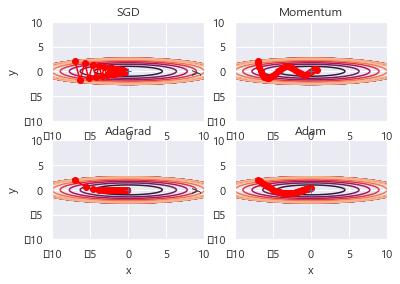

In [6]:
from collections import OrderedDict
from optimizer import *


class parameter(FourLayerNet):

    def f(x, y):
        return x**2 / 20.0 + y**2


    def df(x, y):
        return x / 10.0, 2.0*y

    init_pos = (-7.0, 2.0)
    params = {}
    params['x'], params['y'] = init_pos[0], init_pos[1]
    grads = {}
    grads['x'], grads['y'] = 0, 0


    optimizers = OrderedDict()
    optimizers["SGD"] = SGD(lr=0.95)
    optimizers["Momentum"] = Momentum(lr=0.1)
    optimizers["AdaGrad"] = AdaGrad(lr=1.5)
    optimizers["Adam"] = Adam(lr=0.3)

    idx = 1

    for key in optimizers:
        optimizer = optimizers[key]
        x_history = []
        y_history = []
        params['x'], params['y'] = init_pos[0], init_pos[1]

        for i in range(30):
            x_history.append(params['x'])
            y_history.append(params['y'])

            grads['x'], grads['y'] = df(params['x'], params['y'])
            optimizer.update(params, grads)


        x = np.arange(-10, 10, 0.01)
        y = np.arange(-5, 5, 0.01)

        X, Y = np.meshgrid(x, y) 
        Z = f(X, Y)

        # 외곽선 단순화
        mask = Z > 7
        Z[mask] = 0

        # 그래프 그리기
        plt.subplot(2, 2, idx)
        idx += 1
        plt.plot(x_history, y_history, 'o-', color="red")
        plt.contour(X, Y, Z)
        plt.ylim(-10, 10)
        plt.xlim(-10, 10)
        plt.plot(0, 0, '+')
        #colorbar()
        #spring()
        plt.title(key)
        plt.xlabel("x")
        plt.ylabel("y")

    plt.show()

In [75]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print((x_train, t_train), (x_test, t_test))

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])) (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]))


## Mnist 

In [20]:
from functions import sigmoid, softmax

def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test


def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network


def predict(network, x):
    w1, w2, w3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, w1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, w2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, w3) + b3
    y = softmax(a3)

    return y


x, t = get_data()
network = init_network()

batch_size = 100 # 배치 크기
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size])

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


## 드랍아웃

In [ ]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

===========iteration:0===========
SGD:2.400800831845862
Momentum:2.408882935190614
AdaGrad:1.9426886124364429
Adam:2.2535763743087234
===========iteration:100===========
SGD:1.5527659475795517
Momentum:0.5569801247657845
AdaGrad:0.2677174109859749
Adam:0.5091392494810931
===========iteration:200===========
SGD:0.8035687945739659
Momentum:0.21367153784043275
AdaGrad:0.07065634520897843
Adam:0.13587865267370006
===========iteration:300===========
SGD:0.5518104607549176
Momentum:0.24873913922388474
AdaGrad:0.10530705909360705
Adam:0.2240997282077867
===========iteration:400===========
SGD:0.4347615299242704
Momentum:0.19728386391782593
AdaGrad:0.10393937287792712
Adam:0.10714881181655206
===========iteration:500===========
SGD:0.3698249366569321
Momentum:0.18163563035642152
AdaGrad:0.06312906492861128
Adam:0.09435930793855671
===========iteration:600===========
SGD:0.32617399296240945
Momentum:0.11400494356461163
AdaGrad:0.04926964305704734
Adam:0.06782263706415409
===========iteration:70

Text(0.5, 0, 'iterations')

Text(0, 0.5, 'loss')

(0, 1)

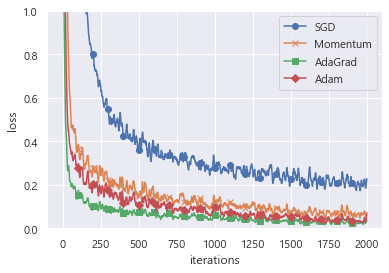

In [86]:
from util import smooth_curve
from multi_layer_net import MultiLayerNet
from optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 모멘텀

In [ ]:
from optimizer import *
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 다중신경망 클래스는 기존 오차역전파 만 사용한 클래스 로 사용한다. 

network = FourLayerNet(input_size = 784, hidden_size_1 = 300,hidden_size_2 = 100, hidden_size_3 = 100 , output_size = 10)
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
momentum = 0.9
v = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

# 모멘텀 

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if v is None:
        v = {}
        for key, val in network.params.items():
            v[key] = np.zeros_like(val)
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

## 미니배치

In [87]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

TypeError: __init__() got an unexpected keyword argument 'hidden_size'